In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from tqdm import tqdm


# fmt: off
# from https://github.com/scverse/pertpy/blob/main/pertpy/tools/_distances/_distances.py
def edistance(X: np.ndarray, Y: np.ndarray, metric: str = "euclidean", **kwargs) -> float:
    sigma_X = pairwise_distances(X, X, metric=metric, **kwargs).mean()
    sigma_Y = pairwise_distances(Y, Y, metric=metric, **kwargs).mean()
    delta = pairwise_distances(X, Y, metric=metric, **kwargs).mean()
    return 2 * delta - sigma_X - sigma_Y

In [2]:
adata = sc.read_h5ad('../../data/Data_GEARS/adamson/perturb_processed.h5ad')
ctrl = adata[adata.obs['condition'] == 'ctrl'].X.toarray()
np.random.seed(24)
ctrl = ctrl[np.random.choice(ctrl.shape[0], size=500, replace=False)]

with open('../extra/more_degs/adamson_degs.pkl', 'rb') as f:
    degs_ls = pickle.load(f)
    degs_ls = {k: v for k, v in degs_ls.items() if k <= 50}

ratio_degs_ls = []; pert_ls = []
for split in range(1,6):
    with open(f'../extra/more_degs/Scouter_adamson_{split}.pkl', 'rb') as f:
        scouter_result_i = pickle.load(f)
    for pert, preds in tqdm(scouter_result_i.items()):
        true = adata[adata.obs['condition'] == pert].X.toarray()
        ratio_pert = {}
        for top_n, degs_n in degs_ls.items():
            degs = degs_n[pert]
            edist_pred = edistance(ctrl[:, degs], preds[:, degs])
            edist_ctrl = edistance(ctrl[:, degs], true[:, degs])
            ratio = edist_pred / edist_ctrl
            ratio_pert[top_n] = ratio ** 0.5
        ratio_degs_ls.append(ratio_pert)
        pert_ls.append(pert)
edist_degs = pd.DataFrame(ratio_degs_ls, index=pert_ls)
print(f'E-Distance on DEGs: {edist_degs.mean()}')

ratio_pca_ls = []; pert_ls = []
for split in range(1,6):
    with open(f'../extra/more_degs/Scouter_adamson_{split}.pkl', 'rb') as f:
        scouter_result_i = pickle.load(f)
    for pert, preds in tqdm(scouter_result_i.items()):
        true = adata[adata.obs['condition'] == pert].X.toarray()
        combined = np.vstack([true, ctrl, preds])
        pca = PCA(n_components=50)
        combined_pca = pca.fit_transform(combined)

        true_pca_all = combined_pca[:true.shape[0]]
        ctrl_pca_all = combined_pca[true.shape[0]:true.shape[0]+ctrl.shape[0]]
        pred_pca_all = combined_pca[true.shape[0]+ctrl.shape[0]:]
        
        ratio_pert = {}
        for npcs in range(20, 51, 10):
            true_pca = true_pca_all[:, :npcs]
            ctrl_pca = ctrl_pca_all[:, :npcs]
            pred_pca = pred_pca_all[:, :npcs]

            edist_pred = edistance(ctrl_pca, pred_pca)
            edist_ctrl = edistance(ctrl_pca, true_pca)
            ratio = edist_pred / edist_ctrl
            ratio_pert[npcs] = ratio ** 0.5
        ratio_pca_ls.append(ratio_pert)
        pert_ls.append(pert)
edist_pca = pd.DataFrame(ratio_pca_ls, index=pert_ls)
print(f'E-Distance on PCA: {edist_pca.mean()}')

100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


E-Distance on DEGs: 20    1.049469
30    1.097365
40    1.143543
50    1.177165
dtype: float64


100%|██████████| 17/17 [00:30<00:00,  1.80s/it]

E-Distance on PCA: 20    1.286956
30    1.311984
40    1.339245
50    1.365316
dtype: float64


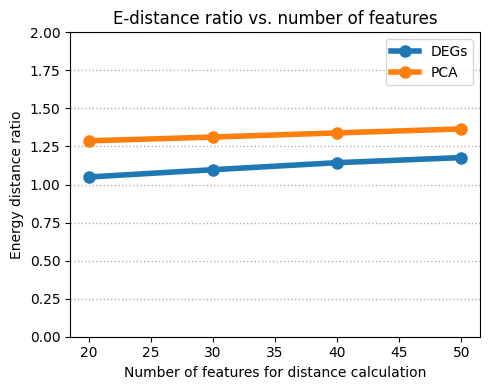

In [3]:
######################## Plot ########################
edist_degs_mean = edist_degs.mean()
edist_pca_mean = edist_pca.mean()
plt.figure(figsize=(5, 4))
plt.plot(edist_degs_mean.index, edist_degs_mean.values, marker='o', label='DEGs', linewidth=4, markersize=8)
plt.plot(edist_pca_mean.index, edist_pca_mean.values, marker='o', label='PCA', linewidth=4, markersize=8)

plt.xlabel('Number of features for distance calculation')
plt.ylabel('Energy distance ratio')
plt.title('E-distance ratio vs. number of features')
plt.ylim(0, 2)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle=':', linewidth=1)
plt.tight_layout()
plt.show()